<i>Updated 10/Dec/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />

# CycleGAN_VIdTIMIT_Train をローカルのWindows上で動作するJupyterで実行する

https://nw.tsuda.ac.jp/lec/GoogleColab/pub/html/CycleGAN_VidTIMIT_Train.html

<font color="red"><b>[注意]</b> Google Colab (tensorflow 2.7.0) 上では <code>tf.keras.utils.load_img()</code>　であったが、本「生成ディープラーニング」のpython 仮想環境 generative (tensorflow 2.2.0) では <code>tf.keras.preprocessing.image.load_img()</code> である。</font>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np

np.random.seed(2022)

# CycleGAN クラスの定義

In [3]:
import tensorflow as tf
import tensorflow_addons as tf_addons
import numpy as np

import matplotlib.pyplot as plt

from collections import deque

import os
import pickle as pkl
import random
import datetime


################################################################################
# Data Loader
################################################################################
class PairDataset():
    def __init__(self, paths_A, paths_B, batch_size= 1, target_size = None, unaligned=False):
        self.paths_A = np.array(paths_A)
        self.paths_B = np.array(paths_B)
        self.target_size = target_size
        self.batch_size = batch_size
        self.unaligned = unaligned

        self.lenA = len(paths_A)
        self.lenB = len(paths_B)
        self.index = 0

    def __len__(self):
        return max(self.lenA, self.lenB)

    def __getitem__(self, index):
        if isinstance(index, slice):
            start, stop, step = index.indices(self.__len__())
            if start == None: start = 0
            if stop == None: stop = self.__len__()
            if step == None:
                if start < stop:
                    step = 1
                elif start > stop:
                    step = -1
                else:
                    step = 0
            return np.array([self.__getitemInt__(i) for i in range(start, stop, step) ])
        else:
            return self.__getitemInt__(index)

    def __getitemInt__(self, index):
        path_A = self.paths_A[index % self.lenA]
        if self.unaligned:
            path_B = self.paths_B[np.random.choice(self.lenB, 1)]
        else:
            path_B = self.paths_B[index % self.lenB]
        img_A = np.array(tf.keras.preprocessing.image.load_img(path_A, target_size = self.target_size))
        img_B = np.array(tf.keras.preprocessing.image.load_img(path_B, target_size = self.target_size))
        img_A = (img_A.astype('float32') - 127.5) / 127.5
        img_B = (img_B.astype('float32') - 127.5) / 127.5
        return np.array([img_A, img_B])

    def __next__(self):
        self.index += 1
        return self.__getitem__(self.index-1)



################################################################################
# Layer
################################################################################
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super().__init__(**kwargs)

    def compute_output_shape(self, s):
        '''
        If you are using "channels_last" configuration
        '''
        return (s[0], s[1]+2*self.padding[0], s[2]+2*self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')


################################################################################
# Model
################################################################################
class CycleGAN():
    def __init__(
        self,
        input_dim,
        learning_rate,
        lambda_validation,
        lambda_reconstr,
        lambda_id,
        generator_type,
        gen_n_filters,
        disc_n_filters,
        buffer_max_length = 50,
        epoch = 0, 
        d_losses = [],
        g_losses = []
    ):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.buffer_max_length = buffer_max_length
        self.lambda_validation = lambda_validation
        self.lambda_reconstr = lambda_reconstr
        self.lambda_id = lambda_id
        self.generator_type = generator_type
        self.gen_n_filters = gen_n_filters
        self.disc_n_filters = disc_n_filters

        # Input shape
        self.img_rows = input_dim[0]
        self.img_cols = input_dim[1]
        self.channels = input_dim[2]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.epoch = epoch
        self.d_losses = d_losses
        self.g_losses = g_losses

        self.buffer_A = deque(maxlen=self.buffer_max_length)
        self.buffer_B = deque(maxlen=self.buffer_max_length)

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**3)
        self.disc_patch = (patch, patch, 1)
        
        self.weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        
        self.compile_models()


    def compile_models(self):
        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()

        self.d_A.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(self.learning_rate, 0.5),
            metrics=['accuracy']
        )
        self.d_B.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(self.learning_rate, 0.5),
            metrics=['accuracy']
        )

        # Build the generators
        if self.generator_type == 'unet':
            self.g_AB = self.build_generator_unet()
            self.g_BA = self.build_generator_unet()
        else:
            self.g_AB = self.build_generator_resnet()
            self.g_BA = self.build_generator_resnet()

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Input images from both domains
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)

        # translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)

        # Identity mapping of images
        img_A_id = self.g_BA(img_A)   # [self memo] ??? translate *A* from domainB to domainA 
        img_B_id = self.g_AB(img_B)   # [self memo] ??? translate *B* from domainA to domainB 
        
        # Discriminators determines validity of traslated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = tf.keras.models.Model(
            inputs=[img_A, img_B],
            outputs=[valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id]
        )
        self.combined.compile(
            loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],  # Mean Squared Error, Mean Absolute Error
            loss_weights=[ self.lambda_validation, self.lambda_validation,
                         self.lambda_reconstr, self.lambda_reconstr,
                         self.lambda_id, self.lambda_id ],
            optimizer=tf.keras.optimizers.Adam(0.0002, 0.5)
        )
        self.d_A.trainable = True
        self.d_B.trainable = True


    def build_generator_unet(self):
        def downsample(layer_input, filters, f_size=4):
            d = tf.keras.layers.Conv2D(
                filters,
                kernel_size=f_size,
                strides=2,
                padding='same',
                kernel_initializer = self.weight_init  # [self memo] added by nitta
            )(layer_input)
            d = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(d)
            d = tf.keras.layers.Activation('relu')(d)
            return d
        def upsample(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            u = tf.keras.layers.Conv2D(
                filters, 
                kernel_size=f_size, 
                strides=1, 
                padding='same',
                kernel_initializer = self.weight_init  # [self memo] added by nitta
            )(u)
            u = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(u)
            u = tf.keras.layers.Activation('relu')(u)
            if dropout_rate:
                u = tf.keras.layers.Dropout(dropout_rate)(u)
            u = tf.keras.layers.Concatenate()([u, skip_input])
            return u
        # Image input
        img = tf.keras.layers.Input(shape=self.img_shape)
        # Downsampling
        d1 = downsample(img, self.gen_n_filters)
        d2 = downsample(d1, self.gen_n_filters*2)
        d3 = downsample(d2, self.gen_n_filters*4)
        d4 = downsample(d3, self.gen_n_filters*8)

        # Upsampling
        u1 = upsample(d4, d3, self.gen_n_filters*4)
        u2 = upsample(u1, d2, self.gen_n_filters*2)
        u3 = upsample(u2, d1, self.gen_n_filters)

        u4 = tf.keras.layers.UpSampling2D(size=2)(u3)
        output_img = tf.keras.layers.Conv2D(
            self.channels, 
            kernel_size=4,
            strides=1, 
            padding='same',
            activation='tanh',
            kernel_initializer = self.weight_init  # [self memo] added by nitta
        )(u4)

        return tf.keras.models.Model(img, output_img)


    def build_generator_resnet(self):
        def conv7s1(layer_input, filters, final):
            y = ReflectionPadding2D(padding=(3,3))(layer_input)
            y = tf.keras.layers.Conv2D(
                filters,
                kernel_size=(7,7),
                strides=1,
                padding='valid',
                kernel_initializer=self.weight_init
            )(y)
            if final:
                y = tf.keras.layers.Activation('tanh')(y)
            else:
                y = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
                y = tf.keras.layers.Activation('relu')(y)
            return y

        def downsample(layer_input, filters):
            y = tf.keras.layers.Conv2D(
                filters, 
                kernel_size=(3,3), 
                strides=2, 
                padding='same',
                kernel_initializer = self.weight_init
            )(layer_input)
            y = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
            y = tf.keras.layers.Activation('relu')(y)
            return y

        def residual(layer_input, filters):
            shortcut = layer_input
            y = ReflectionPadding2D(padding=(1,1))(layer_input)
            y = tf.keras.layers.Conv2D(
                filters,
                kernel_size=(3,3),
                strides=1,
                padding='valid',
                kernel_initializer=self.weight_init
            )(y)
            y = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
            y = tf.keras.layers.Activation('relu')(y)
            y = ReflectionPadding2D(padding=(1,1))(y)
            y = tf.keras.layers.Conv2D(
                filters,
                kernel_size=(3,3),
                strides=1,
                padding='valid',
                kernel_initializer=self.weight_init
            )(y)
            y = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
            return tf.keras.layers.add([shortcut, y])
          
        def upsample(layer_input, filters):
            y = tf.keras.layers.Conv2DTranspose(
                filters, 
                kernel_size=(3,3), 
                strides=2,
                padding='same',
                kernel_initializer=self.weight_init
            )(layer_input)
            y = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
            y = tf.keras.layers.Activation('relu')(y)
            return y

        # Image input
        img = tf.keras.layers.Input(shape=self.img_shape)

        y = img
        y = conv7s1(y, self.gen_n_filters, False)
        y = downsample(y, self.gen_n_filters * 2)
        y = downsample(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = residual(y, self.gen_n_filters * 4)
        y = upsample(y, self.gen_n_filters * 2)
        y = upsample(y, self.gen_n_filters)
        y = conv7s1(y, 3, True)
        output = y
        
        return tf.keras.models.Model(img, output)


    def build_discriminator(self):
        def conv4(layer_input, filters, stride=2, norm=True):
            y = tf.keras.layers.Conv2D(
                filters,
                kernel_size=(4,4),
                strides=stride,
                padding='same',
                kernel_initializer = self.weight_init
              )(layer_input)
            if norm:
                y = tf_addons.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
            y = tf.keras.layers.LeakyReLU(0.2)(y)
            return y

        img = tf.keras.layers.Input(shape=self.img_shape)
        y = conv4(img, self.disc_n_filters, stride=2, norm=False)
        y = conv4(y, self.disc_n_filters*2, stride=2)
        y = conv4(y, self.disc_n_filters*4, stride=2)
        y = conv4(y, self.disc_n_filters*8, stride=1)
        output = tf.keras.layers.Conv2D(
            1,
            kernel_size=4,
            strides=1,
            padding='same',
            kernel_initializer=self.weight_init
        )(y)
        return tf.keras.models.Model(img, output)


    def train_discriminators(self, imgs_A, imgs_B, valid, fake):
        # Translate images to opposite domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        
        self.buffer_B.append(fake_B)
        self.buffer_A.append(fake_A)

        fake_A_rnd = random.sample(self.buffer_A, min(len(self.buffer_A), len(imgs_A))) # random sampling without replacement 
        fake_B_rnd = random.sample(self.buffer_B, min(len(self.buffer_B), len(imgs_B)))
        
        # Train the discriminators (original images=real / translated = fake)
        dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A_rnd, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B_rnd, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total discriminator loss
        d_loss_total = 0.5 * np.add(dA_loss, dB_loss)

        return (
            d_loss_total[0], 
            dA_loss[0], dA_loss_real[0], dA_loss_fake[0],
            dB_loss[0], dB_loss_real[0], dB_loss_fake[0],
            d_loss_total[1], 
            dA_loss[1], dA_loss_real[1], dA_loss_fake[1],
            dB_loss[1], dB_loss_real[1], dB_loss_fake[1]
        )


    def train_generators(self, imgs_A, imgs_B, valid):
        # Train the generators
        return self.combined.train_on_batch(
          [imgs_A, imgs_B], 
          [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B]
        )


    def train(self, data_loader, epochs, batch_size=1, run_folder='./run', print_step_interval=100, save_epoch_interval=100):
        start_time = datetime.datetime.now()
        # Adversarial loss ground truthes
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        steps = len(data_loader) // batch_size
        for epoch in range(self.epoch, epochs):
            step_d_losses = []
            step_g_losses = []
            for step in range(steps):
                start = step * batch_size
                end = start + batch_size
                pairs = data_loader[start:end]    # ((a,b), (a, b), ....)
                imgs_A, imgs_B = [], []
                for img_A, img_B in pairs:
                    imgs_A.append(img_A)
                    imgs_B.append(img_B)

                imgs_A = np.array(imgs_A)
                imgs_B = np.array(imgs_B)

                step_d_loss = self.train_discriminators(imgs_A, imgs_B, valid, fake)
                step_g_loss = self.train_generators(imgs_A, imgs_B, valid)

                step_d_losses.append(step_d_loss)
                step_g_losses.append(step_g_loss)

                elapsed_time = datetime.datetime.now() - start_time
                if (step+1) % print_step_interval == 0:
                    print(f'Epoch {epoch+1}/{epochs} {step+1}/{steps} [D loss: {step_d_loss[0]:.3f} acc: {step_d_loss[7]:.3f}][G loss: {step_g_loss[0]:.3f} adv: {np.sum(step_g_loss[1:3]):.3f} recon: {np.sum(step_g_loss[3:5]):.3f} id: {np.sum(step_g_loss[5:7]):.3f} time: {elapsed_time:}')

            d_loss = np.mean(step_d_losses, axis=0)
            g_loss = np.mean(step_g_losses, axis=0)

            elapsed_time = datetime.datetime.now() - start_time

            elapsed_time = datetime.datetime.now() - start_time
            print(f'Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.3f} acc: {d_loss[7]:.3f}][G loss: {g_loss[0]:.3f} adv: {np.sum(g_loss[1:3]):.3f} recon: {np.sum(g_loss[3:5]):.3f} id: {np.sum(g_loss[5:7]):.3f} time: {elapsed_time:}')
                    
            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            self.epoch += 1
            if (self.epoch) % save_epoch_interval == 0:
                self.save(run_folder, self.epoch)
                self.save(run_folder)

        self.save(run_folder, self.epoch)
        self.save(run_folder)


    def save(self, folder, epoch=None):
        self.save_params(folder, epoch)
        self.save_weights(folder,epoch)


    @staticmethod
    def load(folder, epoch=None):
        params = CycleGAN.load_params(folder, epoch)
        gan = CycleGAN(*params)
        gan.load_weights(folder, epoch)
        return gan


    def save_weights(self, run_folder, epoch=None):
        if epoch is None:
            self.save_model_weights(self.combined, os.path.join(run_folder, 'weights/combined-weights.h5'))
            self.save_model_weights(self.d_A, os.path.join(run_folder, 'weights/d_A-weights.h5'))
            self.save_model_weights(self.d_B, os.path.join(run_folder, 'weights/d_B-weights.h5'))
            self.save_model_weights(self.g_AB, os.path.join(run_folder, 'weights/g_AB-weights.h5'))
            self.save_model_weights(self.g_BA, os.path.join(run_folder, 'weights/g_BA-weights.h5'))
        else:
            self.save_model_weights(self.combined, os.path.join(run_folder, f'weights/combined-weights_{epoch}.h5'))
            self.save_model_weights(self.d_A, os.path.join(run_folder, f'weights/d_A-weights_{epoch}.h5'))
            self.save_model_weights(self.d_B, os.path.join(run_folder, f'weights/d_B-weights_{epoch}.h5'))
            self.save_model_weights(self.g_AB, os.path.join(run_folder, f'weights/g_AB-weights_{epoch}.h5'))
            self.save_model_weights(self.g_BA, os.path.join(run_folder, f'weights/g_BA-weights_{epoch}.h5'))


    def load_weights(self, run_folder, epoch=None):
        if epoch is None:
            self.load_model_weights(self.combined, os.path.join(run_folder, 'weights/combined-weights.h5'))
            self.load_model_weights(self.d_A, os.path.join(run_folder, 'weights/d_A-weights.h5'))
            self.load_model_weights(self.d_B, os.path.join(run_folder, 'weights/d_B-weights.h5'))
            self.load_model_weights(self.g_AB, os.path.join(run_folder, 'weights/g_AB-weights.h5'))
            self.load_model_weights(self.g_BA, os.path.join(run_folder, 'weights/g_BA-weights.h5'))
        else:
            self.load_model_weights(self.combined, os.path.join(run_folder, f'weights/combined-weights_{epoch}.h5'))
            self.load_model_weights(self.d_A, os.path.join(run_folder, f'weights/d_A-weights_{epoch}.h5'))
            self.load_model_weights(self.d_B, os.path.join(run_folder, f'weights/d_B-weights_{epoch}.h5'))
            self.load_model_weights(self.g_AB, os.path.join(run_folder, f'weights/g_AB-weights_{epoch}.h5'))
            self.load_model_weights(self.g_BA, os.path.join(run_folder, f'weights/g_BA-weights_{epoch}.h5'))


    def save_model_weights(self, model, filepath):
        dpath, fname = os.path.split(filepath)
        if dpath != '' and not os.path.exists(dpath):
            os.makedirs(dpath)
        model.save_weights(filepath)


    def load_model_weights(self, model, filepath):
        model.load_weights(filepath)


    def save_params(self, folder, epoch=None):
        if epoch is None:
            filepath = os.path.join(folder, 'params.pkl')
        else:
            filepath = os.path.join(folder, f'params_{epoch}.pkl')

        dpath, fname = os.path.split(filepath)
        if dpath != '' and not os.path.exists(dpath):
            os.makedirs(dpath)

        with open(filepath, 'wb') as f:
            pkl.dump([
                self.input_dim,
                self.learning_rate,
                self.lambda_validation,
                self.lambda_reconstr,
                self.lambda_id,
                self.generator_type,
                self.gen_n_filters,
                self.disc_n_filters,
                self.buffer_max_length,
                self.epoch,
                self.d_losses,
                self.g_losses
              ], f)


    @staticmethod
    def load_params(folder, epoch=None):
        if epoch is None:
            filepath = os.path.join(folder, 'params.pkl')
        else:
            filepath = os.path.join(folder, f'params_{epoch}.pkl')

        with open(filepath, 'rb') as f:
            params = pkl.load(f)
        return params


    def generate_image(self, img_A, img_B):
        gen_A = self.generate_image_from_A(img_A)
        gen_B = self.generate_image_from_B(img_B)
        return np.concatenate([gen_A, gen_B], axis=0)


    def generate_image_from_A(self, img_A):
        fake_B = self.g_AB.predict(img_A)      # Translate images to the other domain
        reconstr_A = self.g_BA.predict(fake_B)  # Translate back to original domain
        id_A = self.g_BA.predict(img_A)    # ID the images
        return np.concatenate([img_A, fake_B, reconstr_A, id_A])


    def generate_image_from_B(self, img_B):
        fake_A = self.g_BA.predict(img_B)
        reconstr_B = self.g_AB.predict(fake_A)
        id_B = self.g_AB.predict(img_B)
        return np.concatenate([img_B, fake_A, reconstr_B, id_B])


    @staticmethod
    def showImages(imgs, trans, recon, idimg, w=2.8, h=2.8, filepath=None):
        N = len(imgs)
        M = len(imgs[0])
        titles = ['Original', 'Translated', 'Reconstructed', 'ID']

        fig, ax = plt.subplots(N, M, figsize=(w*M, h*N))
        for i in range(N):
            for j in range(M):
                ax[i][j].imshow(imgs[i][j])
                ax[i][j].set_title(title[j])
                ax[i][j].axis('off')

        if not filepath is None:
            dpath, fname = os.path.split(filepath)
            if dpath != '' and not os.path.exists(dpath):
                os.makedirs(dpath)
            fig.savefig(filepath, dpi=600)
            plt.close()
        else:
            plt.show()
        

    def showLoss(self, xlim=[], ylim=[]):
        print('loss AB')
        self.showLossAB(xlim, ylim)
        print('loss BA')
        self.showLossBA(xlim, ylim)


    def showLossAB(self, xlim=[], ylim=[]):
        g = np.array(self.g_losses)
        g_loss = g[:, 0]
        g_adv = g[:, 1]
        g_recon = g[:, 3]
        g_id = g[:, 5]
        CycleGAN.plot_history(
            [g_loss, g_adv, g_recon, g_id],
            ['g_loss', 'AB discrim', 'AB cycle', 'AB id'],
            xlim,
            ylim)

    def showLossBA(self, xlim=[], ylim=[]):
        g = np.array(self.g_losses)
        g_loss = g[:, 0]
        g_adv = g[:, 2]
        g_recon = g[:, 4]
        g_id = g[:, 6]
        CycleGAN.plot_history(
            [g_loss, g_adv, g_recon, g_id],
            ['g_loss', 'BA discrim', 'BA cycle', 'BA id'],
            xlim,
            ylim)


    @staticmethod
    def plot_history(vals, labels, xlim=[], ylim=[]):
        colors = ['red', 'blue', 'green', 'orange', 'black', 'pink']
        n = len(vals)
        fig, ax = plt.subplots(1, 1, figsize=(12,6))
        for i in range(n):
            ax.plot(vals[i], c=colors[i], label=labels[i])
        ax.legend(loc='upper right')
        ax.set_xlabel('epochs')
        # ax.set_ylabel('loss')

        if xlim != []:
            ax.set_xlim(xlim[0], xlim[1])
        if ylim != []:
            ax.set_ylim(ylim[0], ylim[1])
        
        plt.show()

# Preparing VidTIMIT dataset

Official WWW of VidTIMIT dataset: http://conradsanderson.id.au/vidtimit/

zip files of 2 persons of VidTIMIT dataset: <br />
https://zenodo.org/record/158963/files/fadg0.zip  <br />
https://zenodo.org/record/158963/files/faks0.zip  <br />

zip files mirrored on my Google Drive: <br />
https://drive.google.com/uc?id=1_Fv4p9MDNphMZMnLpEvtCtnwXgN8N5Cj <br />
https://drive.google.com/uc?id=1Y8j7ThPVqB0gbx4hb9aMEp9Ptr9wFuoz <br />

## VidTIMIT データセットを用意する

VidTIMIT データセットの公式ページ: http://conradsanderson.id.au/vidtimit/

VidTIMIT の2名の顔写真の zip ファイル: <br />
https://zenodo.org/record/158963/files/fadg0.zip <br />
https://zenodo.org/record/158963/files/faks0.zip <br />


自分の Google Drive 上にミラーした顔写真: <br />
https://drive.google.com/uc?id=1_Fv4p9MDNphMZMnLpEvtCtnwXgN8N5Cj <br />
https://drive.google.com/uc?id=1Y8j7ThPVqB0gbx4hb9aMEp9Ptr9wFuoz <br />

<font color="red"><b>[注意]</b> 上記のfadg0.zip, faks0.zip をブラウザを使って手動でダウンロードして、以下のフォルダに解凍したものとする。</font>

In [4]:
VidTIMIT_fnames = [ 'fadg0', 'faks0']
data_dir = 'D:\\data\\torch_book1\\ch06'

In [5]:
!dir {data_dir}

 ドライブ D のボリューム ラベルがありません。
 ボリューム シリアル番号は 606C-349E です

 D:\data\torch_book1\ch06 のディレクトリ

2021/12/10  16:23    <DIR>          .
2021/12/10  16:23    <DIR>          ..
2021/12/10  16:20    <DIR>          fadg0
2021/12/10  16:20    <DIR>          faks0
               0 個のファイル                   0 バイト
               4 個のディレクトリ  1,758,399,877,120 バイトの空き領域


In [6]:
IMAGE_SIZE = 128

In [7]:
import os
import glob

imgA_paths = glob.glob(os.path.join(data_dir, VidTIMIT_fnames[0], 'video/*/[0-9]*'))
imgB_paths = glob.glob(os.path.join(data_dir, VidTIMIT_fnames[1], 'video/*/[0-9]*'))

In [8]:
import numpy as np

validation_split = 0.05

nA, nB = len(imgA_paths), len(imgB_paths)
splitA = int(nA * (1 - validation_split))
splitB = int(nB * (1 - validation_split))

np.random.shuffle(imgA_paths)
np.random.shuffle(imgB_paths)

train_imgA_paths = imgA_paths[:splitA]
test_imgA_paths = imgA_paths[splitA:]
train_imgB_paths = imgB_paths[:splitB]
test_imgB_paths = imgB_paths[splitB:]

In [9]:
print(nA, nB)

2732 2138


In [10]:
# Image: [-1, 1] --> [0, 1]
def M1P1_ZeroP1(imgs):
    imgs = (imgs + 1) * 0.5
    return np.clip(imgs, 0, 1)

# Image: [0, 1] --> [-1, 1]
def ZeroP1_M1P1(imgs):
    return imgs * 2 - 1

In [11]:
pair_flow = PairDataset(train_imgA_paths, train_imgB_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE))
test_pair_flow = PairDataset(test_imgA_paths, test_imgB_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE))

# 画像データをチェックする

In [12]:
# Display images
# 画像を表示する。
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showImages(imgs, rows=-1, cols=-1, w=2, h=2):
    N = len(imgs)
    if rows < 0: rows = 1
    if cols < 0: cols = (N + rows -1) // rows
    fig, ax = plt.subplots(rows, cols, figsize=(w*cols, h*rows))
    idx = 0
    for row in range(rows):
        for col in range(cols) :
            if rows == 1 and cols == 1:
                axis = ax
            elif rows == 1:
                axis = ax[col]
            elif cols == 1:
                axis = ax[row]
            else:
                axis = ax[row][col]

            if idx < N:
                axis.imshow(imgs[idx])
            axis.axis('off')
            idx += 1
    plt.show()

In [13]:
# Display images with the file paths.
# 画像のpathの配列を受け取って、画像を表示する。
%matplotlib inline
import tensorflow as tf

def showImagesByPath(fnames,rows=-1, cols=-1, w=2, h=2):
    imgs = [ tf.keras.preprocessing.image.load_img(fname) for fname in fnames] # if not exist, try 'tf.keras.utils.load_img'
    showImages(imgs, rows, cols, w, h)

(128, 128, 3) (128, 128, 3)


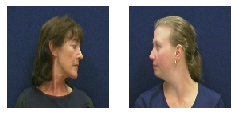

In [14]:
a, b = next(pair_flow)
print(a.shape, b.shape)
showImages([M1P1_ZeroP1(a), M1P1_ZeroP1(b)])

# ニューラルネットワーク・モデルを定義する

In [16]:
gan = CycleGAN(
    input_dim = (IMAGE_SIZE, IMAGE_SIZE, 3),
    learning_rate = 0.0002,
    buffer_max_length = 50,
    lambda_validation = 1,
    lambda_reconstr = 10,
    lambda_id = 2,
    generator_type = 'unet',
    gen_n_filters = 32,
    disc_n_filters = 32
)

# 訓練する

In [17]:
save_path = 'run'

In [18]:
gan.train(
    pair_flow,
    epochs=1,
    batch_size=1,
    run_folder = save_path
)

Epoch 1/1 100/2595 [D loss: 0.270 acc: 0.499][G loss: 2.149 adv: 0.625 recon: 0.121 id: 0.158 time: 0:00:25.918334
Epoch 1/1 200/2595 [D loss: 0.194 acc: 0.723][G loss: 2.112 adv: 0.672 recon: 0.116 id: 0.141 time: 0:00:38.707313
Epoch 1/1 300/2595 [D loss: 0.166 acc: 0.754][G loss: 1.862 adv: 0.562 recon: 0.104 id: 0.128 time: 0:00:51.332847
Epoch 1/1 400/2595 [D loss: 0.142 acc: 0.808][G loss: 1.721 adv: 0.576 recon: 0.095 id: 0.098 time: 0:01:03.930779
Epoch 1/1 500/2595 [D loss: 0.234 acc: 0.663][G loss: 2.175 adv: 0.805 recon: 0.116 id: 0.105 time: 0:01:16.385007
Epoch 1/1 600/2595 [D loss: 0.321 acc: 0.539][G loss: 2.254 adv: 0.866 recon: 0.115 id: 0.118 time: 0:01:28.864714
Epoch 1/1 700/2595 [D loss: 0.169 acc: 0.724][G loss: 2.071 adv: 0.521 recon: 0.128 id: 0.136 time: 0:01:41.378852
Epoch 1/1 800/2595 [D loss: 0.202 acc: 0.714][G loss: 2.262 adv: 0.950 recon: 0.111 id: 0.102 time: 0:01:53.800394
Epoch 1/1 900/2595 [D loss: 0.156 acc: 0.782][G loss: 1.852 adv: 0.553 recon: 0.

In [19]:
! dir {os.path.join(save_path, 'weights')}

 ドライブ G のボリューム ラベルは Google Drive です
 ボリューム シリアル番号は 1983-1116 です

 G:\マイドライブ\DeepLearning\book14\ch05\weights のディレクトリ

2021/12/10  17:13    <DIR>          .
2021/12/10  17:13    <DIR>          ..
2021/12/10  17:13        17,974,248 combined-weights_1.h5
2021/12/10  17:13         2,804,360 d_A-weights_1.h5
2021/12/10  17:13         2,804,368 d_B-weights_1.h5
2021/12/10  17:13         6,232,272 g_AB-weights_1.h5
2021/12/10  17:13         6,232,272 g_BA-weights_1.h5
2021/12/10  17:13        17,974,248 combined-weights.h5
2021/12/10  17:13         2,804,360 d_A-weights.h5
2021/12/10  17:13         2,804,368 d_B-weights.h5
2021/12/10  17:13         6,232,272 g_AB-weights.h5
2021/12/10  17:13         6,232,272 g_BA-weights.h5
              10 個のファイル          72,095,040 バイト
               2 個のディレクトリ  97,505,456,128 バイトの空き領域


In [20]:
gan.train(
    pair_flow,
    epochs=3,
    batch_size=1,
    run_folder = save_path,
    print_step_interval=500
)

Epoch 2/3 500/2595 [D loss: 0.158 acc: 0.777][G loss: 1.554 adv: 0.448 recon: 0.095 id: 0.078 time: 0:01:05.726503
Epoch 2/3 1000/2595 [D loss: 0.154 acc: 0.847][G loss: 1.999 adv: 0.914 recon: 0.092 id: 0.084 time: 0:02:12.090036
Epoch 2/3 1500/2595 [D loss: 0.134 acc: 0.799][G loss: 1.525 adv: 0.499 recon: 0.087 id: 0.079 time: 0:03:16.667689
Epoch 2/3 2000/2595 [D loss: 0.180 acc: 0.747][G loss: 1.366 adv: 0.131 recon: 0.104 id: 0.099 time: 0:04:19.123717
Epoch 2/3 2500/2595 [D loss: 0.095 acc: 0.927][G loss: 1.681 adv: 0.606 recon: 0.090 id: 0.088 time: 0:05:21.575702
Epoch 2/3 [D loss: 0.121 acc: 0.853][G loss: 1.828 adv: 0.743 recon: 0.092 id: 0.083 time: 0:05:33.414047
Epoch 3/3 500/2595 [D loss: 0.187 acc: 0.752][G loss: 2.148 adv: 1.119 recon: 0.087 id: 0.079 time: 0:06:36.295628
Epoch 3/3 1000/2595 [D loss: 0.052 acc: 0.979][G loss: 1.266 adv: 0.305 recon: 0.081 id: 0.075 time: 0:07:39.598419
Epoch 3/3 1500/2595 [D loss: 0.082 acc: 0.912][G loss: 1.786 adv: 0.813 recon: 0.082

# 画像を生成する

A-->B-->A, ID


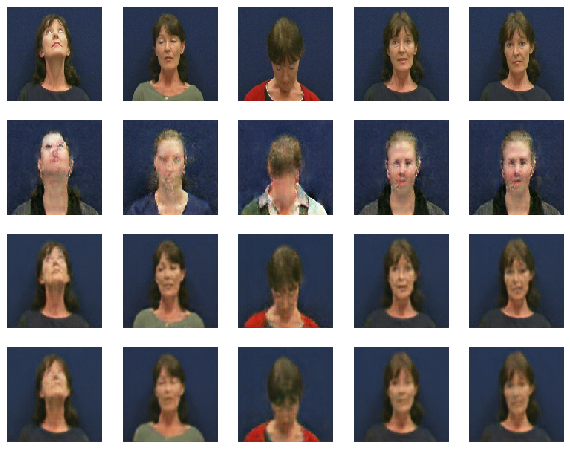

B-->A-->B, ID


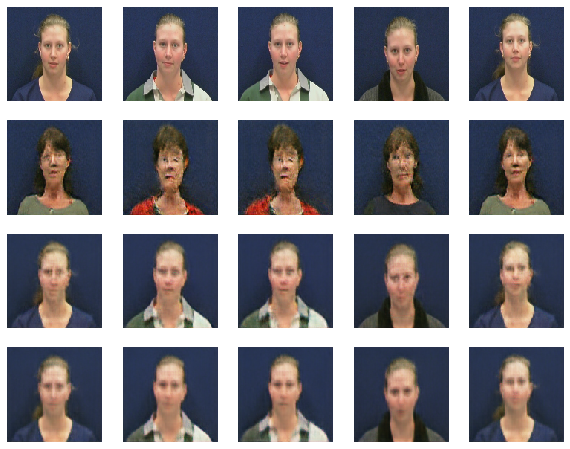

In [21]:
# Display generated and cycle images.
# 生成画像とサイクル画像を表示する。

test_pairs = test_pair_flow[:5]

test_imgsA = test_pairs[:,0]
test_imgsB = test_pairs[:,1]

imgsAB = gan.generate_image_from_A(test_imgsA)
imgsBA = gan.generate_image_from_B(test_imgsB)

print('A-->B-->A, ID')
showImages(M1P1_ZeroP1(imgsAB), 4)

print('B-->A-->B, ID')
showImages(M1P1_ZeroP1(imgsBA), 4)

# 学習過程のlossと精度を確認する

loss AB


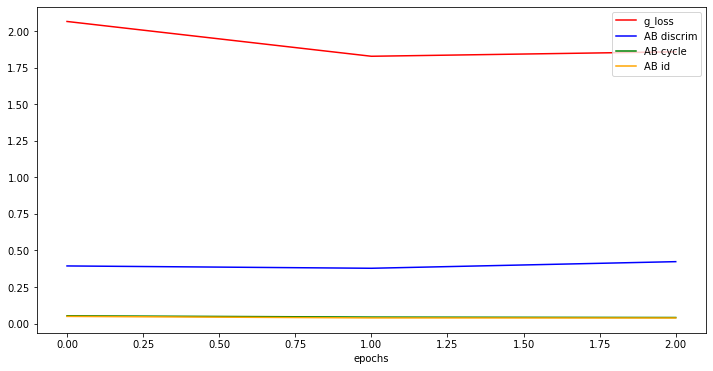

loss BA


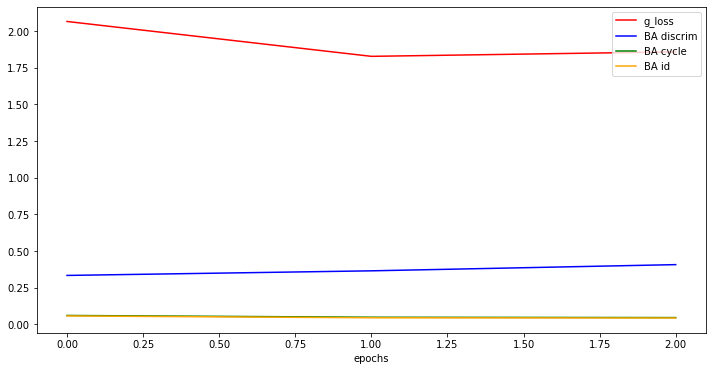

In [22]:
# Display the graph of losses in training
%matplotlib inline

gan.showLoss()

# セーブしたファイルをロードして、さらに学習を進める

In [23]:
# Load the saved parameters and weights.
# 保存してある学習結果をロードする。

gan_work = CycleGAN.load(save_path)

# Display the epoch count of the model.
# training のepoch回数を表示する。

print(gan_work.epoch)

3


In [24]:
# Training in addition
# 追加で training する。

gan_work.train(
    pair_flow,
    epochs=5,
    batch_size=1,
    run_folder = save_path,
    print_step_interval=500,
    save_epoch_interval = 5
)

Epoch 4/5 500/2595 [D loss: 0.116 acc: 0.828][G loss: 2.308 adv: 1.310 recon: 0.085 id: 0.076 time: 0:01:16.074482
Epoch 4/5 1000/2595 [D loss: 0.061 acc: 0.963][G loss: 1.828 adv: 0.818 recon: 0.084 id: 0.083 time: 0:02:20.553777
Epoch 4/5 1500/2595 [D loss: 0.114 acc: 0.833][G loss: 1.684 adv: 0.822 recon: 0.072 id: 0.070 time: 0:03:24.854975
Epoch 4/5 2000/2595 [D loss: 0.069 acc: 0.955][G loss: 1.731 adv: 0.610 recon: 0.094 id: 0.093 time: 0:04:29.440514
Epoch 4/5 2500/2595 [D loss: 0.046 acc: 0.987][G loss: 1.792 adv: 0.841 recon: 0.079 id: 0.082 time: 0:05:33.991188
Epoch 4/5 [D loss: 0.092 acc: 0.904][G loss: 1.914 adv: 0.915 recon: 0.084 id: 0.080 time: 0:05:46.905766
Epoch 5/5 500/2595 [D loss: 0.065 acc: 0.966][G loss: 1.834 adv: 0.839 recon: 0.083 id: 0.081 time: 0:06:52.312289
Epoch 5/5 1000/2595 [D loss: 0.071 acc: 0.960][G loss: 1.708 adv: 0.787 recon: 0.077 id: 0.075 time: 0:07:56.608458
Epoch 5/5 1500/2595 [D loss: 0.040 acc: 0.988][G loss: 1.597 adv: 0.786 recon: 0.068

A-->B-->A, ID


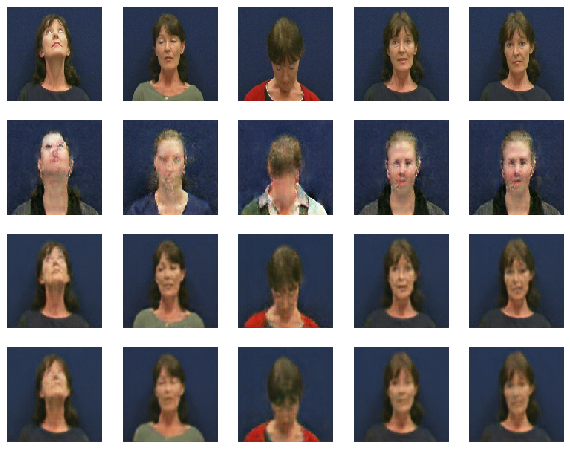

B-->A-->B, ID


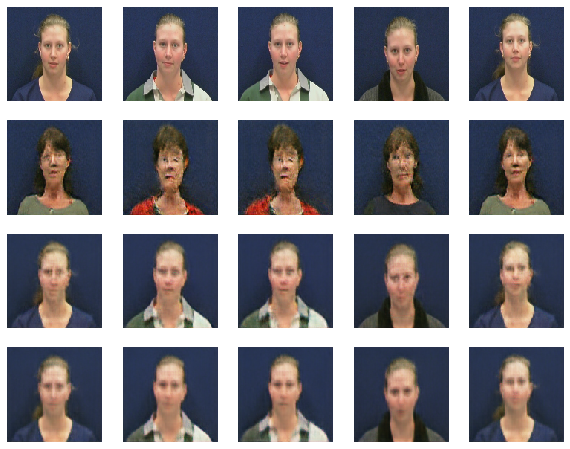

In [25]:
# Display generated and cycle images.
# 生成画像とサイクル画像を表示する。

test_pairs = test_pair_flow[:5]

test_imgsA = test_pairs[:,0]
test_imgsB = test_pairs[:,1]

imgsAB = gan.generate_image_from_A(test_imgsA)
imgsBA = gan.generate_image_from_B(test_imgsB)

print('A-->B-->A, ID')
showImages(M1P1_ZeroP1(imgsAB), 4)

print('B-->A-->B, ID')
showImages(M1P1_ZeroP1(imgsBA), 4)

loss AB


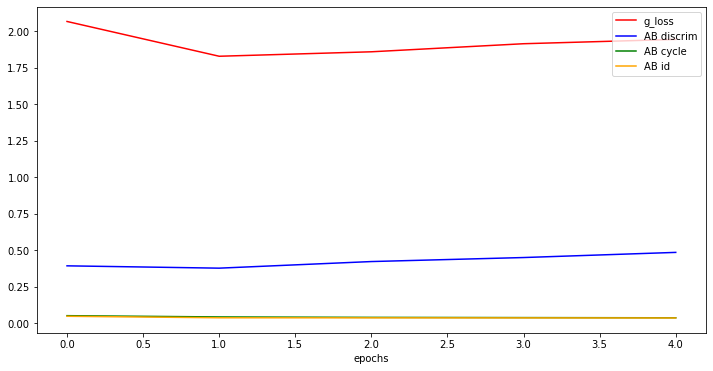

loss BA


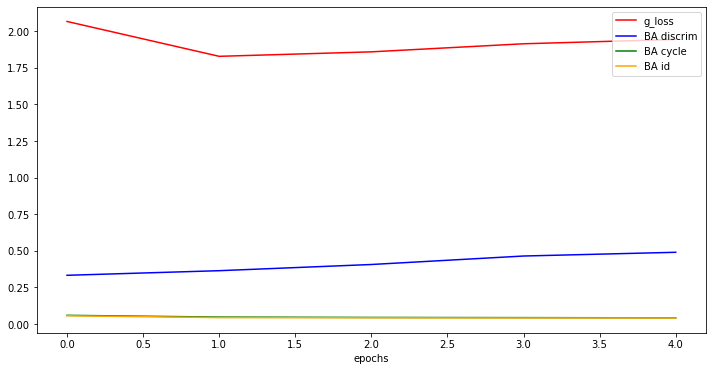

In [26]:
# Display the graph of losses in training
%matplotlib inline

gan_work.showLoss()